<a href="https://colab.research.google.com/github/marekpiotradamczyk/ml_uwr_23/blob/main/Assignments/Assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Assignment 7

**Submission deadline:**
* **lab session in the week 22-26.1.24**

**Points: 5 points**


Have a look at the following implementation of Decision Tree Classifier. Be aware that for the sake of further simplicity it does not allow for categorical variables as typical Decision Trees do.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class DecisionTreeClassifierScratch:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y, depth=0):
        if depth == self.max_depth or len(set(y)) == 1:
            return {'class': max(set(y), key=list(y).count)}

        # Find the best split
        best_feature, best_threshold = self.find_best_split(X, y)


        '''
        If the find_best_split method returns None,
        it means that further splitting is not possible (all features are constant).
        In such cases, a leaf node is created with the majority class.
        '''
        if best_feature is None:
            return {'class': max(set(y), key=list(y).count)}

        '''
        X[best_feature]: Extracts the values of the selected feature (best_feature) from the DataFrame X.
        <= best_threshold: Compares each value of the selected feature to the specified threshold (best_threshold).
        This comparison results in a boolean array where each element is True if the corresponding value
        is less than or equal to the threshold, and False otherwise.
        '''
        # Split the dataset
        left_indices = X[best_feature] <= best_threshold
        right_indices = ~left_indices

        # Recursively build the tree
        left_subtree = self.fit(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self.fit(X[right_indices], y[right_indices], depth + 1)

        return {'feature': best_feature, 'threshold': best_threshold,
                'left': left_subtree, 'right': right_subtree}

    def find_best_split(self, X, y):
        best_gini = 1.0
        best_feature = None
        best_threshold = None

        for feature in X.columns:
            thresholds = X[feature].unique()
            for threshold in thresholds:
                left_indices = X[feature] <= threshold
                right_indices = ~left_indices

                gini = self.calculate_gini_impurity(y[left_indices], y[right_indices])

                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def calculate_gini_impurity(self, left_labels, right_labels):
        left_size = len(left_labels)
        right_size = len(right_labels)
        total_size = left_size + right_size

        if total_size == 0:
            return 0

        p_left = left_size / total_size
        p_right = right_size / total_size

        gini_left = 1.0 - sum((np.sum(left_labels == c) / left_size) ** 2 for c in set(left_labels))
        gini_right = 1.0 - sum((np.sum(right_labels == c) / right_size) ** 2 for c in set(right_labels))

        gini_impurity = p_left * gini_left + p_right * gini_right

        return gini_impurity

    def predict_single(self, tree, sample):
        if 'class' in tree:
            return tree['class']

        if sample[tree['feature']] <= tree['threshold']:
            return self.predict_single(tree['left'], sample)
        else:
            return self.predict_single(tree['right'], sample)

    def predict(self, X):
        return [self.predict_single(self.tree, sample) for _, sample in X.iterrows()]


# Load Iris dataset
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target

# Use only two features for visualization purposes
X_iris = iris_df[['petal length (cm)', 'petal width (cm)']]
y_iris = iris_df['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=0.2, random_state=42)

# Create and train the decision tree classifier from scratch
clf = DecisionTreeClassifierScratch(max_depth=4)
clf.tree = clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")



Accuracy: 1.00


In [ ]:
def plot_decision_boundary(X, y, tree, feature_names, title="Decision Boundary"):
    # Plot the decision boundary
    plt.figure(figsize=(8, 6))

    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = np.array(tree.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=feature_names))).reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap='viridis', edgecolor='k', s=40)
    plt.title(title)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.show()

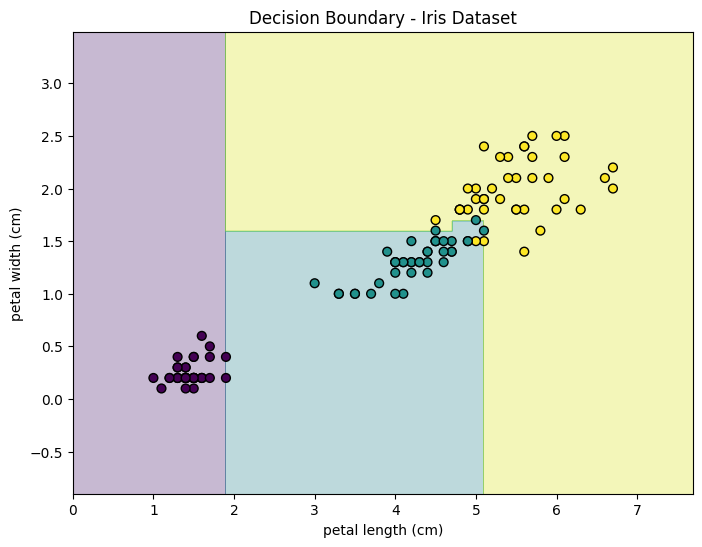

In [ ]:
feature_names = X_iris.columns
plot_decision_boundary(X_train, y_train, clf, feature_names, title="Decision Boundary - Iris Dataset")


# Problem 1 [1p]

Based on above implementation, create a Decision Tree model which uses entropy and not Gini. Verify its accuracy on Iris (as above) and plot decision boundaries.

In [ ]:
class DecisionTreeClassifier_entropy:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y, depth=0):
        if depth == self.max_depth or len(set(y)) == 1:
            return {'class': max(set(y), key=list(y).count)}

        best_feature, best_threshold = self.find_best_split(X, y)

        if best_feature is None:
            return {'class': max(set(y), key=list(y).count)}

        left_indices = X[best_feature] <= best_threshold
        right_indices = ~left_indices

        left_subtree = self.fit(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self.fit(X[right_indices], y[right_indices], depth + 1)

        return {'feature': best_feature, 'threshold': best_threshold,
                'left': left_subtree, 'right': right_subtree}

    def find_best_split(self, X, y):
        best_entr = np.log2(len(set(y)))
        best_feature = None
        best_threshold = None

        for feature in X.columns:
            thresholds = X[feature].unique()
            for threshold in thresholds:
                left_indices = X[feature] <= threshold
                right_indices = ~left_indices

                entr = self.calculate_entropy(y[left_indices], y[right_indices])

                if entr < best_entr:
                    best_entr = entr
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def calculate_entropy(self, left_labels, right_labels):
        left_size = len(left_labels)
        right_size = len(right_labels)
        total_size = left_size + right_size

        if total_size == 0:
            return 0

        p_left = left_size / total_size
        p_right = right_size / total_size

        entropy_left = -sum((np.sum(left_labels == c) / left_size) * np.log2(np.sum(left_labels == c) / left_size)
                            for c in set(left_labels) if np.sum(left_labels == c) > 0)

        entropy_right = -sum((np.sum(right_labels == c) / right_size) * np.log2(np.sum(right_labels == c) / right_size)
                             for c in set(right_labels) if np.sum(right_labels == c) > 0)

        entropy = p_left * entropy_left + p_right * entropy_right

        return entropy


    def predict_single(self, tree, sample):
        if 'class' in tree:
            return tree['class']

        if sample[tree['feature']] <= tree['threshold']:
            return self.predict_single(tree['left'], sample)
        else:
            return self.predict_single(tree['right'], sample)

    def predict(self, X):
        return [self.predict_single(self.tree, sample) for _, sample in X.iterrows()]


# Load Iris dataset
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target

# Use only two features for visualization purposes
X_iris = iris_df[['petal length (cm)', 'petal width (cm)']]
y_iris = iris_df['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=0.2, random_state=42)

# Create and train the decision tree classifier from scratch
clf2 = DecisionTreeClassifier_entropy(max_depth=4)
clf2.tree = clf2.fit(X_train, y_train)

# Predict on the test set
y_pred = clf2.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")



Accuracy: 1.00


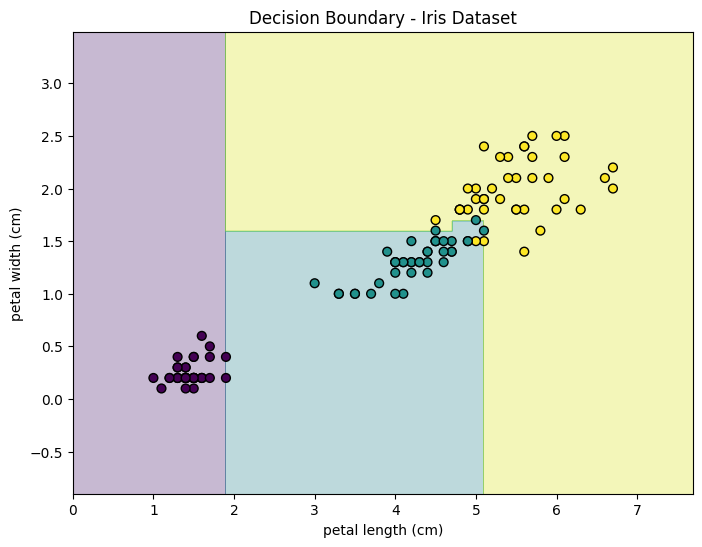

In [ ]:
feature_names = X_iris.columns
plot_decision_boundary(X_train, y_train, clf2, feature_names, title="Decision Boundary - Iris Dataset")

# Problem 2 [2p]

Default versions of Decision Trees use entropy or Gini to find best features. However, there are is no global objective function that they optimize while training.

Based on the above implementation, please write Decision Tree Classifier that explicitely minimizes the crossentropy function, and makes splits in a greedy way that creates the biggest drop in the Negative Log Likelihood. Verify its accuracy on Iris (as above) and plot decision boundaries.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class DecisionTreeClassifier_cross_entropy:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y, depth=0):
        if depth == self.max_depth or len(set(y)) == 1 or len(y) == 0:
            return {'class': max(set(y), key=list(y).count) if len(y) > 0 else None}

        best_feature, best_threshold = self.find_best_split(X, y)

        if best_feature is None:
            return {'class': max(set(y), key=list(y).count)}

        left_indices = X[best_feature] <= best_threshold
        right_indices = ~left_indices

        left_subtree = self.fit(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self.fit(X[right_indices], y[right_indices], depth + 1)

        return {'feature': best_feature, 'threshold': best_threshold,
                'left': left_subtree, 'right': right_subtree}

    def find_best_split(self, X, y):
        best_entr = np.inf  # Use infinity for initialization
        best_feature = None
        best_threshold = None

        for feature in X.columns:
            thresholds = X[feature].unique()
            for threshold in thresholds:
                left_indices = X[feature] <= threshold
                right_indices = ~left_indices

                entr = self.calculate_cross_entropy(y[left_indices], y[right_indices])

                if entr < best_entr:
                    best_entr = entr
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def calculate_cross_entropy(self, x, y):

        if(len(y)==0): return float('inf')

        bcount_x = np.bincount(x)
        bcount_y = np.bincount(y)

        max_len = max(len(bcount_y), len(bcount_x))
        count_y = np.pad(bcount_y, (0, max_len - len(bcount_y)), 'constant')
        count_x = np.pad(bcount_x, (0, max_len - len(bcount_x)), 'constant')

        count_x = count_x / np.sum(bcount_x)
        count_y = count_y / np.sum(bcount_y)

        count_y[count_y == 0] = 1

        res = -np.sum(count_x * np.log2(count_y))

        return res

    def predict_single(self, tree, sample):
        if 'class' in tree:
            return tree['class']

        if sample[tree['feature']] <= tree['threshold']:
            return self.predict_single(tree['left'], sample)
        else:
            return self.predict_single(tree['right'], sample)

    def predict(self, X):
        return [self.predict_single(self.tree, sample) for _, sample in X.iterrows()]

# Load Iris dataset
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target

# Use only two features for visualization purposes
X_iris = iris_df[['petal length (cm)', 'petal width (cm)']]
y_iris = iris_df['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=0.2, random_state=42)

# Create and train the decision tree classifier from scratch
clf2 = DecisionTreeClassifier_cross_entropy(max_depth=4)
clf2.tree = clf2.fit(X_train, y_train)

# Predict on the test set
y_pred = clf2.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.97


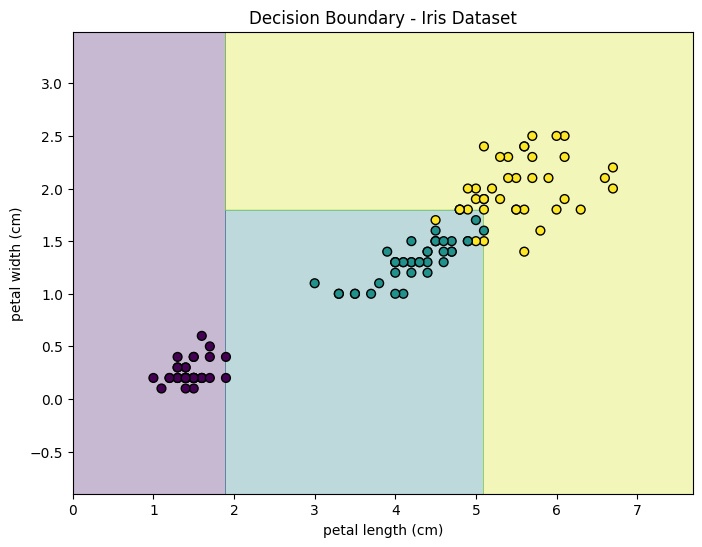

In [ ]:
feature_names = X_iris.columns
plot_decision_boundary(X_train, y_train, clf2, feature_names, title="Decision Boundary - Iris Dataset")

# Problem 3 [2p]

Based on the above implementation, create a Decision Tree Regressor which greedily chooses a split which locally minimizes MSE the most. Verify its correctness as shown below.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

class DecisionTreeRegressor:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y, depth=0):
        if depth == self.max_depth or len(np.unique(y)) == 1:
            return {'value': np.mean(y)}

        # Find the best split
        best_feature, best_threshold = self.find_best_split(X, y)

        if best_feature is None:
            return {'value': np.mean(y)}

        # Split the dataset
        left_indices = X[best_feature] <= best_threshold
        right_indices = ~left_indices

        # Recursively build the tree
        left_subtree = self.fit(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self.fit(X[right_indices], y[right_indices], depth + 1)

        return {'feature': best_feature, 'threshold': best_threshold,
                'left': left_subtree, 'right': right_subtree}

    def find_best_split(self, X, y):
        best_mse = np.inf
        best_feature = None
        best_threshold = None

        for feature in X.columns:
            thresholds = X[feature].unique()
            for threshold in thresholds:
                left_indices = X[feature] <= threshold
                right_indices = ~left_indices

                mse = self.calculate_mse(y[left_indices], y[right_indices])

                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def calculate_mse(self, left_labels, right_labels):
        mse_left = np.mean((left_labels - np.mean(left_labels))**2)
        mse_right = np.mean((right_labels - np.mean(right_labels))**2)

        mse = mse_left + mse_right
        return mse

    def predict_single(self, tree, sample):
        if 'value' in tree:
            return tree['value']

        if sample[tree['feature']] <= tree['threshold']:
            return self.predict_single(tree['left'], sample)
        else:
            return self.predict_single(tree['right'], sample)

    def predict(self, X):
        return [self.predict_single(self.tree, sample) for _, sample in X.iterrows()]



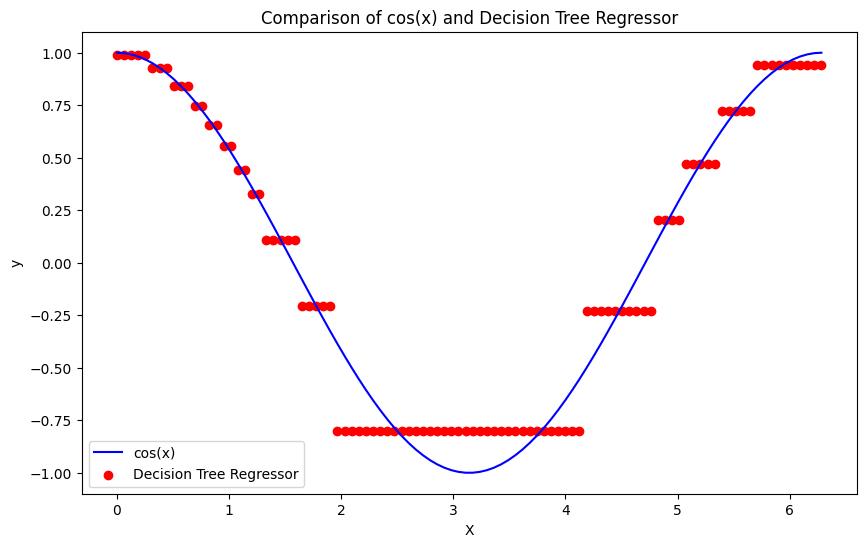

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# Generate dataset
X = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)  # X values
y = np.cos(X).ravel()  # y values (cos(x))


# Create and train the decision tree regressor from scratch
regressor = DecisionTreeRegressor(max_depth=4)
regressor.fit(X, y)

# Predict on the generated dataset
y_pred = regressor.predict(X)

# Plotting both the cos(x) and the decision tree regressor predictions
plt.figure(figsize=(10, 6))
plt.plot(X, y, label='cos(x)', color='blue')
plt.scatter(X, y_pred, label='Decision Tree Regressor', color='red')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Comparison of cos(x) and Decision Tree Regressor')
plt.legend()
plt.show()

